# Abnormal Behaviour Detection

In [1]:
#Importing Libraries
import tensorflow as tf
from tensorflow import keras
import tensorboard
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from random import shuffle
from sklearn.model_selection import train_test_split

##Building Model
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed,Dropout, Activation, Flatten,Conv2D, MaxPooling2D,LSTM,Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Reading Data From Folders

In [2]:
#Folder in which the converted images will be saved
outs_dataFrames=".//"
img_size=100

# Building Function that will read videos using opencv and save them as Dataframe on ##outs_dataFrames_Folder
def extract_Frames(videos_folder):
    '''
    Reading the videos from a certain folders and get the frames to store them in another
    folder.

    Parameters:
        videos_folder (str):The folder path that contains the videos.

    Returns:
        None : only reading the videos   
    '''
    dataset1=[]
    images1=[]
    limit1=0
    count1=0
    
    dataset2=[]
    images2=[]
    limit2=0
    count2=0
    num_frames=10
    c1=0
    c2=0

    for file in os.listdir(videos_folder):
        if file[0:1]=="V":
            file_path=os.path.join(videos_folder,file)
            cap=cv2.VideoCapture(file_path)
            
            success=True
            while success:
                success,image=cap.read()
                if not success:
                    break
               
                image=cv2.resize(image,(img_size,img_size))
                c1+=1
            
                if image is not None:
                    images1.append(np.array(image))
                    limit1+=1
                    count1+=1
                    if limit1==num_frames:
                        limit1=0
                        dataset1.append(np.array([images1,np.array([0,1])]))
                        images1=[]
                        
        
        elif file[0:1]=="N":
            file_path=os.path.join(videos_folder,file)
            cap=cv2.VideoCapture(file_path)
    
            success=True
            while success:
                success,image=cap.read()
                if not success:
                    break
                
                image=cv2.resize(image,(img_size,img_size))
                
                
            
                
                images2.append(np.array(image))
                limit2+=1
                count2+=1
                if limit2==num_frames:
                    limit2=0
                    dataset2.append(np.array([images2,np.array([1,0])]))
                    images2=[]
                c2+=1
    print(c1)
    print(c2)
                
    dataset=dataset1+dataset2
    
    return dataset
        


In [3]:
data=extract_Frames("../input/egypt-violence-nonviolencedataset")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


17614
21042


In [4]:
np.array(data[0][0]).shape

(10, 100, 100, 3)

## Setting Model Parameters

In [5]:
## settting parameters for Funtion of creating Dataset
total=41015

## Setting Parameters for Model
optm='SGD'
lr=.01
epochs=25
batch_size=5
num_frames=10

### Loading and Splitting Your Data

In [6]:
training, test = train_test_split(data, train_size= 0.9)
Train,Valid=train_test_split(training, train_size= 0.8)

In [7]:
X_train = np.array([i[0] for i in Train]).reshape(-1, 10, img_size, img_size, 3)
y_train = np.array([i[1] for i in Train])

X_valid = np.array([i[0] for i in Valid]).reshape(-1, 10, img_size, img_size, 3)
y_valid = np.array([i[1] for i in Valid])

X_test = np.array([i[0] for i in test]).reshape(-1, 10, img_size, img_size, 3)
y_test = np.array([i[1] for i in test])

In [8]:
X_train = X_train.astype('float32')/255
X_valid = X_valid.astype('float32')/255
X_test=X_test.astype('float32')/255

In [9]:
print("X_train shape "+ str(X_train.shape))
print("X_valid shape "+ str(X_valid.shape))
print("X_test shape "+ str(X_test.shape))

X_train shape (2782, 10, 100, 100, 3)
X_valid shape (696, 10, 100, 100, 3)
X_test shape (387, 10, 100, 100, 3)


# Building The Model

In [10]:
from tensorflow.keras.layers import LSTM, Bidirectional, Conv2D, Dense, Flatten, MaxPooling2D, TimeDistributed, Reshape, MaxPooling3D
from tensorflow.keras.models import Sequential

cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(10, img_size,img_size, 3), padding="same"))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling3D((1, 2,2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling3D((1, 2,2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling3D((1, 2,2)))
#cnn.add(Flatten())
cnn.add(Reshape((10, 6400)))

#cnn.summary()

lstm_fw = LSTM(units=32)
lstm_bw = LSTM(units=32, go_backwards = True)

cnn.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(2, activation='sigmoid'))

cnn.summary()

2021-12-31 16:59:00.021130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 16:59:00.123325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 16:59:00.124379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 16:59:00.128793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 100, 100, 64)  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 98, 98, 64)    36928     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 47, 47, 64)    36928     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 23, 23, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 21, 21, 64)    36928     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 10, 10, 64)    0

## Model Hypermaters Tuning

In [11]:
cnn.compile(loss='categorical_crossentropy',optimizer="SGD",metrics=['accuracy'])

In [12]:
##CallBacks
early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.5,
                                                  patience=3,
                                                  min_lr=0.00005,
                                                  verbose=1)

#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

#callbacks
checkpoint_path="D:\\00000000\\Check_Points\\cp{epoch:04d}.kbt"
checkpoint_dir=os.path.dirname(checkpoint_path)

callback=ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,vrbose=1)

In [13]:
history=cnn.fit(X_train,y_train,epochs=12,validation_data=(X_valid,y_valid),batch_size=8, verbose=1)

2021-12-31 16:59:03.130219: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3338400000 exceeds 10% of free system memory.
2021-12-31 16:59:06.419928: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3338400000 exceeds 10% of free system memory.
2021-12-31 16:59:08.866862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2021-12-31 16:59:12.541028: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


348/348 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6132

2021-12-31 16:59:41.980192: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 835200000 exceeds 10% of free system memory.
2021-12-31 16:59:42.905780: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 835200000 exceeds 10% of free system memory.


348/348 [==============================] - 38s 81ms/step - loss: 0.6513 - accuracy: 0.6132 - val_loss: 0.6021 - val_accuracy: 0.7170
Epoch 2/12
348/348 [==============================] - 24s 70ms/step - loss: 0.4497 - accuracy: 0.7937 - val_loss: 0.2767 - val_accuracy: 0.9080
Epoch 3/12
348/348 [==============================] - 24s 70ms/step - loss: 0.2597 - accuracy: 0.8943 - val_loss: 0.2433 - val_accuracy: 0.8894
Epoch 4/12
348/348 [==============================] - 26s 73ms/step - loss: 0.1755 - accuracy: 0.9274 - val_loss: 0.1109 - val_accuracy: 0.9598
Epoch 5/12
348/348 [==============================] - 26s 73ms/step - loss: 0.1282 - accuracy: 0.9504 - val_loss: 0.1393 - val_accuracy: 0.9425
Epoch 6/12
348/348 [==============================] - 24s 70ms/step - loss: 0.0918 - accuracy: 0.9644 - val_loss: 0.1254 - val_accuracy: 0.9583
Epoch 7/12
348/348 [==============================] - 24s 70ms/step - loss: 0.0673 - accuracy: 0.9763 - val_loss: 0.0740 - val_accuracy: 0.9698
Epo

In [14]:
cnn.save(".//training")

2021-12-31 17:04:27.450269: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## **Model Evaluation**

In [15]:
Test_Predictions=cnn.predict(X_test)

2021-12-31 17:04:41.215768: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 464400000 exceeds 10% of free system memory.


In [16]:
y_test_lst=[]
y_test_pred_lst=[]

for j in y_test:
    if j[0]>j[1]:
        y_test_lst.append(0)
    else:
        y_test_lst.append(1)


for i in Test_Predictions:
    if i[0]>i[1]:
        y_test_pred_lst.append(0)
    else:
        y_test_pred_lst.append(1)


df_evaluation=pd.DataFrame({"y_test":y_test_lst,"y_test_pred":y_test_pred_lst})

In [17]:
df_evaluation

,y_test,y_test_pred
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
382,0,0
383,1,1
384,0,0
385,1,1


In [18]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(df_evaluation["y_test"], df_evaluation["y_test_pred"])
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9612403100775194


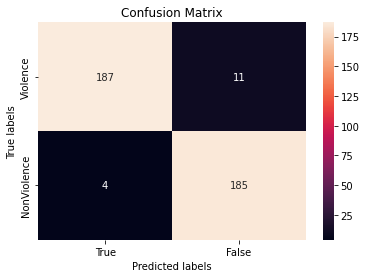

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix
import seaborn as sns

ax= plt.subplot()
cm=confusion_matrix(df_evaluation["y_test"], df_evaluation["y_test_pred"])
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticksa
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['Violence', 'NonViolence']);

In [20]:
from sklearn.metrics import classification_report
#Calculating classification Report :  
#classification_report(y_true, y_pred, labels=None, target_names=None,sample_weight=None, digits=2, output_dict=False)

ClassificationReport = classification_report(df_evaluation["y_test"],df_evaluation["y_test_pred"])
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       198
           1       0.94      0.98      0.96       189

    accuracy                           0.96       387
   macro avg       0.96      0.96      0.96       387
weighted avg       0.96      0.96      0.96       387



## Loss and Accuracy Model Evaluation

In [21]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.651296,0.613228,0.602107,0.716954
1,0.449684,0.793674,0.276737,0.908046
2,0.259719,0.894321,0.243254,0.889368
3,0.175458,0.927390,0.110880,0.959770
4,0.128194,0.950395,0.139293,0.942529
5,0.091798,0.964414,0.125389,0.958333
6,0.067348,0.976276,0.074027,0.969828
7,0.039425,0.986341,0.065313,0.977012
8,0.039853,0.984544,0.093585,0.968391
9,0.025259,0.992811,0.071137,0.981322


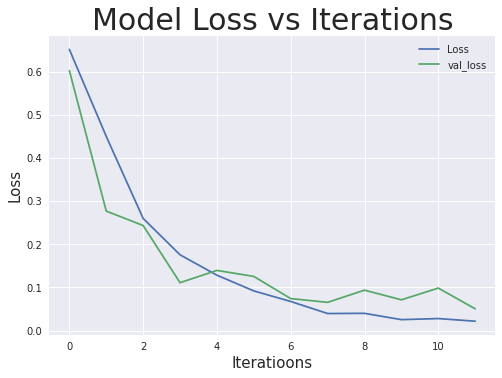

In [22]:
## plot Model loss versus iterations using Matplotlib
plt.style.use("seaborn")
p1=plt.plot(history.history["loss"])
p2=plt.plot(history.history["val_loss"])
plt.xlabel("Iteratioons",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.title("Model Loss vs Iterations",fontsize=30)
plt.legend(["Loss","val_loss"])

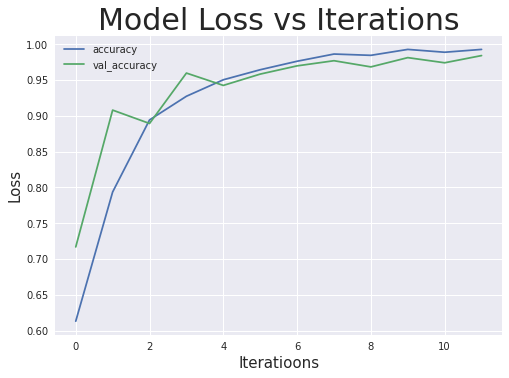

In [23]:
## plot Model accuracy versus iterations using Matplotlib
plt.style.use("seaborn")
p1=plt.plot(history.history["accuracy"])
p2=plt.plot(history.history["val_accuracy"])
plt.xlabel("Iteratioons",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.title("Model Loss vs Iterations",fontsize=30)
plt.legend(["accuracy","val_accuracy"])

## Check Model with plotting and Video Frames

In [24]:
def Check_Model_Plotting(X_test,Test_Predictions,video_num=0):
    '''
    Check the accurcy of model by giving the test data versus the plotting frames.

    Parameters:
        X_test (np_array):frames of test data.
        Test_predictions (float): probability of predicted labels by model 

    Returns:
        None : only plotting the videos frames with model prediction label to test them.  
    '''
    
    
    
    
    try:
        assert video_num in range(0,X_test.shape[0]) 
    except:
        print("Enter values of video number between 0 to "+str(X_test.shape[0]))
    
    plt.figure(figsize=(15,10))
    
    video_prediction=Test_Predictions[video_num]
    if video_prediction[0]>video_prediction[1]:
        print("This video is non violence with probability equal to "+str(video_prediction[0]))
    else:
        print("This video is violence with probability equal to "+str(video_prediction[1]))
    
    for i in range(10):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(X_test[video_num][i])
        ax.figure.set_size_inches(15,15)
 

This video is non violence with probability equal to 0.9924625


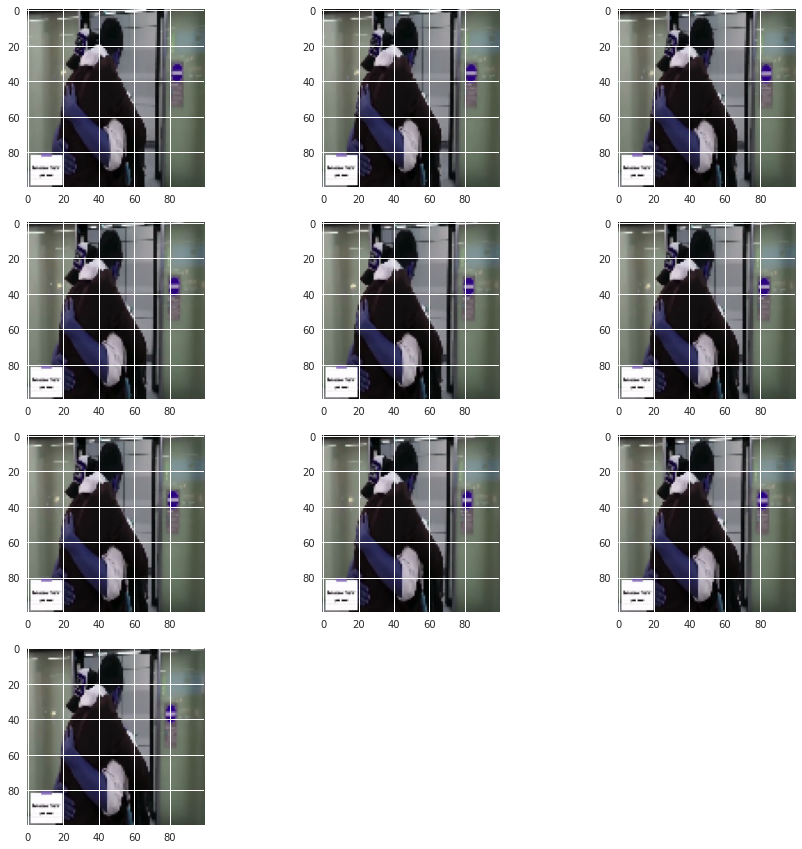

In [25]:
Check_Model_Plotting(X_test,Test_Predictions,video_num=10)